# How to Train an Antibody Developability Model

### (with foundation model embeddings)

## Introduction

Antibody development is the process of engineering therapeutic antibodies with desirable **biophysical properties** such as high expression, stability, and low aggregation propensity.  
Unlike simple point mutations in proteins, antibody optimization is especially complex: the pairing of **VH (variable heavy)** and **VL (variable light)** domains creates a vast combinatorial space where even small changes can dramatically alter folding, binding, or developability.  

Predicting these effects experimentally is costly and time-consuming, which is why **machine learning on antibody sequence data** has become such an important tool. By learning representations of antibody sequences, protein language models can capture sequence–structure–function relationships that help guide design choices.

<p align="center">
  <img src="https://cdn-uploads.huggingface.co/production/uploads/66df5f0644a0a0d033c50463/lRPvjjJr-7UFNDWlG-7aY.png" alt="My Image" style="width:75%;"/>
</p>

In [24]:
## first things first, imports

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import torch
from tqdm.auto import tqdm
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer

### This Dataset

The [GDPa1](https://huggingface.co/datasets/ginkgo-datapoints/GDPa1) dataset provides paired VH/VL antibody sequences with experimentally measured **developability assays**, including expression yield, hydrophobicity, stability, and self-interaction.  
This makes it a valuable benchmark for testing whether protein language models like **p-IgGen** can generate embeddings that generalize across assays and predict developability outcomes.  

In the sections below, we demonstrate how to:
- Embed VH/VL pairs with p-IgGen,  
- Train simple regression models on different assay targets, and  
- Evaluate generalization with **cluster- and isotype-aware cross-validation**.  

In [12]:
model_name = "ollieturnbull/p-IgGen" # our foundation model
df = load_dataset("ginkgo-datapoints/GDPa1")["train"].to_pandas()
df.head()

,antibody_id,antibody_name,Titer,Purity,SEC %Monomer,SMAC,HIC,HAC,PR_CHO,PR_Ova,...,hc_protein_sequence,hc_dna_sequence,vl_protein_sequence,lc_protein_sequence,lc_dna_sequence,hierarchical_cluster_fold,random_fold,hierarchical_cluster_IgG_isotype_stratified_fold,light_aligned_aho,heavy_aligned_aho
0,GDPa1-001,abagovomab,140.25,98.530,97.010,2.730,2.590,NaN,0.337837,0.263108,...,MRAWIFFLLCLAGRALAQVKLQESGAELARPGASVKLSCKASGYTF...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIELTQSPASLSASVGETVTITCQASENIYSYLAWHQQKQGKSPQL...,MRAWIFFLLCLAGRALADIELTQSPASLSASVGETVTITCQASENI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,1,2,2,DIELTQSPASLSASVGETVTITCQAS--ENIY------SYLAWHQQ...,QVKLQES-GAELARPGASVKLSCKASG-YTFTN-----YWMQWVKQ...
1,GDPa1-002,abituzumab,193.31,99.825,97.620,2.745,2.545,3.690,0.205246,0.100155,...,MRAWIFFLLCLAGRALAQVQLQQSGGELAKPGASVKVSCKASGYTF...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKL...,MRAWIFFLLCLAGRALADIQMTQSPSSLSASVGDRVTITCRASQDI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,1,4,0,DIQMTQSPSSLSASVGDRVTITCRAS--QDIS------NYLAWYQQ...,QVQLQQS-GGELAKPGASVKVSCKASG-YTFSS-----FWMHWVRQ...
2,GDPa1-003,abrezekimab,114.75,98.350,89.055,2.740,2.705,NaN,0.138773,0.101180,...,MRAWIFFLLCLAGRALAQVTLKESGPVLVKPTETLTLTCTVSGFSL...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIQMTQSPSSLSASVGDRVTITCLASEDISNYLAWYQQKPGKAPKL...,MRAWIFFLLCLAGRALADIQMTQSPSSLSASVGDRVTITCLASEDI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,2,2,2,DIQMTQSPSSLSASVGDRVTITCLAS--EDIS------NYLAWYQQ...,QVTLKES-GPVLVKPTETLTLTCTVSG-FSLTN-----YHVQWIRQ...
3,GDPa1-004,abrilumab,327.32,98.575,98.605,2.715,2.565,1.005,0.000000,0.054971,...,MRAWIFFLLCLAGRALAQVQLVQSGAEVKKPGASVKVSCKVSGYTL...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIQMTQSPSSVSASVGDRVTITCRASQGISSWLAWYQQKPGKAPKL...,MRAWIFFLLCLAGRALADIQMTQSPSSVSASVGDRVTITCRASQGI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,1,3,0,DIQMTQSPSSVSASVGDRVTITCRAS--QGIS------SWLAWYQQ...,QVQLVQS-GAEVKKPGASVKVSCKVSG-YTLSD-----LSIHWVRQ...
4,GDPa1-005,adalimumab,313.39,99.300,96.120,2.705,2.495,NaN,0.183387,0.085628,...,MRAWIFFLLCLAGRALAEVQLVESGGGLVQPGRSLRLSCAASGFTF...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIQMTQSPSSLSASVGDRVTITCRASQGIRNYLAWYQQKPGKAPKL...,MRAWIFFLLCLAGRALADIQMTQSPSSLSASVGDRVTITCRASQGI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,0,2,0,DIQMTQSPSSLSASVGDRVTITCRAS--QGIR------NYLAWYQQ...,EVQLVES-GGGLVQPGRSLRLSCAASG-FTFDD-----YAMHWVRQ...


## Quick Primer
### Antibody Sequences: VH and VL
Antibodies are Y-shaped proteins built from two chains:
- **VH (Variable Heavy)**: the heavy-chain variable region that contributes to antigen binding.  
- **VL (Variable Light)**: the light-chain variable region that pairs with VH to form the complete binding site.  

Together, VH and VL encode the amino acid sequences that define an antibody’s specificity and biochemical properties.  
In this dataset, each row includes both VH and VL sequences for a given antibody.  


![image/png](https://cdn-uploads.huggingface.co/production/uploads/66df5f0644a0a0d033c50463/PIjgj1bK2YxyIZ1rj1M8S.png)
*Image from https://www.antibody-creativebiolabs.com/antibody-structure-isotypes.htm*

### Available Properties

Each antibody has associated experimental measurements across 5 assays (not all measurements are available for every sequence):

- **Titer**: Expression yield of the antibody in mammalian cells.  
- **HIC** (*Hydrophobic Interaction Chromatography*): A proxy for hydrophobicity and aggregation propensity.  
- **PR_CHO**: Polyreactivity in CHO (*Chinese hamster ovary*) cells - this measures how much an antibody binds to other proteins that it's not supposed to.
- **Tm2**: Thermal stability (melting temperature of the CH2 domain).  
- **AC-SINS_pH7.4**: Self-interaction propensity (higher values often correlate with poor developability).


### A Note on Isotype Effects
The antibodies in this GDPa1 dataset have different IgG subclasses (IgG1, IgG2, IgG4). Some of the measurements, such as  **thermal stability** (Tm2), are strongly influenced by the antibody’s **isotype**. Different IgG subclasses (e.g., IgG1, IgG2, IgG4) have systematic differences in CH2 domain stability, which can overshadow subtle sequence-level variation---so consider including the subclass as a feature in your models! To illustrate this, we can make a simple boxplot of `Tm2` values grouped by isotype.

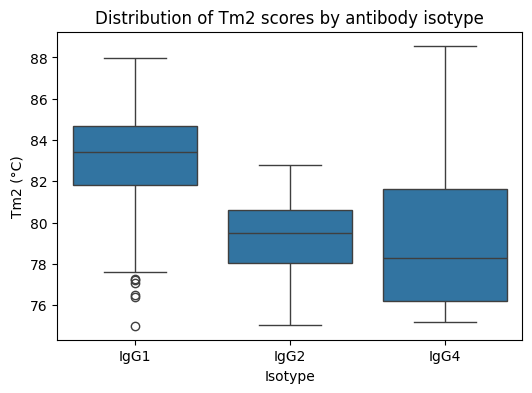

In [10]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="hc_subtype", y="Tm2")
plt.title("Distribution of Tm2 scores by antibody isotype")
plt.xlabel("Isotype")
plt.ylabel("Tm2 (°C)")
plt.show()

## Let's go!

In this tutorial, we select one target at a time (e.g., `HIC`) and train a simple linear model on pooled sequence embeddings to assess predictivity.  

We start by importing the core libraries for data handling, visualization, statistics, and modeling. Using Hugging Face Datasets, we load the **GDPa1** dataset into a Pandas DataFrame, inspect the available assay columns, and check for missing values. For this tutorial, we select a single developability target (here `"HIC"`, though others like `"Titer"` could also be chosen) and drop rows with missing measurements so that the dataset is ready for model training and evaluation.

In [15]:
# Show number of NaNs per assay
print(df[["Titer", "HIC", "PR_CHO", "Tm2", 'AC-SINS_pH7.4']].isna().sum())
target = "HIC"

# Example: Just predict HIC, so we'll drop NaN rows for that
df = df.dropna(subset=[target])

Titer             3
HIC               0
PR_CHO           45
Tm2              49
AC-SINS_pH7.4     0
dtype: int64


The VH and VL protein sequences for each antibody are combined into a single tokenized string input for **p-IgGen**. We prepend a `"1"` token at the start and append a `"2"` token at the end to mark sequence boundaries.

In [16]:
# Tokenize the sequences
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Paired sequence handling: Concatenate heavy and light chains and add beginning ("1") and end ("2") tokens
# (e.g. ["EVQLV...", "DIQMT..."] -> "1E V Q L V ... D I Q M T ... 2")
sequences = [
    "1" + " ".join(heavy) + " ".join(light) + "2"
    for heavy, light in zip(
        df["vh_protein_sequence"],
        df["vl_protein_sequence"],
    )
]

print(sequences[0])

1Q V K L Q E S G A E L A R P G A S V K L S C K A S G Y T F T N Y W M Q W V K Q R P G Q G L D W I G A I Y P G D G N T R Y T H K F K G K A T L T A D K S S S T A Y M Q L S S L A S E D S G V Y Y C A R G E G N Y A W F A Y W G Q G T T V T V S SD I E L T Q S P A S L S A S V G E T V T I T C Q A S E N I Y S Y L A W H Q Q K Q G K S P Q L L V Y N A K T L A G G V S S R F S G S G S G T H F S L K I K S L Q P E D F G I Y Y C Q H H Y G I L P T F G G G T K L E I K2


We load the p-IgGen model and pass in batches of tokenized VH/VL sequences to obtain hidden-state embeddings. For each sequence, we compute the mean-pooled representation across tokens, resulting in a fixed-length vector that captures sequence-level information about the antibody.


In [17]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

# Takes about 60 seconds for 242 sequences on my CPU, and 1.1s on GPU
batch_size = 16
mean_pooled_embeddings = []
for i in tqdm(range(0, len(sequences), batch_size)):
    batch = tokenizer(sequences[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
    outputs = model(batch["input_ids"].to(device), return_rep_layers=[-1], output_hidden_states=True)
    embeddings = outputs["hidden_states"][-1].detach().cpu().numpy()
    mean_pooled_embeddings.append(embeddings.mean(axis=1))
mean_pooled_embeddings = np.concatenate(mean_pooled_embeddings)

  0%|          | 0/16 [00:00<?, ?it/s]

With embeddings as features (`X`) and the chosen assay measurement as the target (`y`), we split the data into training and test sets. A ridge regression model is fit on the training set, providing a straightforward baseline to evaluate how informative p-IgGen embeddings are for predicting antibody developability properties.

In [18]:
# Train a linear regression on these
X = mean_pooled_embeddings
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lm = Ridge()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

We evaluate the model using **Spearman’s rank correlation** between predicted and true assay values, which is more robust than linear correlation when the relationship is non-linear. Finally, we visualize predictions against ground truth in a scatter plot to assess how well the model generalizes. 

We get approximately `0.41` Spearman correlation using these embeddings with linear regression to predict `HIC`.

SignificanceResult(statistic=np.float64(0.41341124897148246), pvalue=np.float64(0.0031521527808128337))


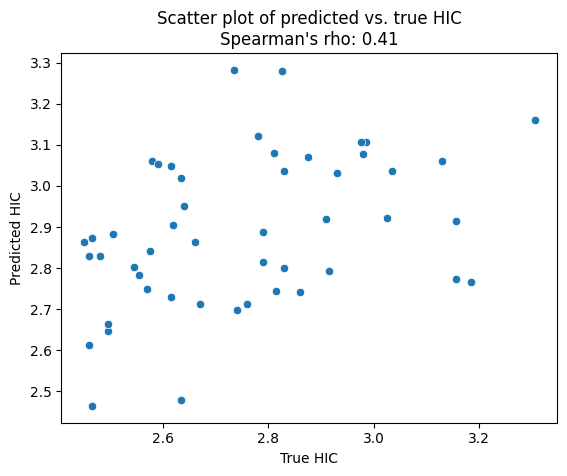

In [19]:
# Calculate score
print(spearmanr(y_pred, y_test))

sns.scatterplot(x=y_test, y=y_pred)
plt.title(f"Scatter plot of predicted vs. true {target}\nSpearman's rho: {spearmanr(y_pred, y_test)[0]:.2f}")
plt.xlabel(f"True {target}")
plt.ylabel(f"Predicted {target}")
plt.show()

## Cross-Validation with Isotype-Stratified Folds

In our previous experiment, we allowed the training and test sets to be randomly generated. The problem with this is that there may be near-identical antibodies split between training and test, essentially creating label leakage. To understand how our model behaves when presented with totally new antibodies, we want to evaluate our regressor with **cluster + isotype-aware
cross-validation**.

Each fold holds out **entire sequence clusters (but still containing a mix of different IgG subclasses)**, so the model is tested on *novel* families rather than near-duplicates. Below, we reuse the previously computed embeddings and our target `y`, but we use the pre-computed fold assignment in `df['hierarchical_cluster_IgG_isotype_stratified_fold']` to define train/test splits. Now, we train fresh `Ridge` models on each training split and evaluate with Spearman correlation on the held-out fold.

Averaged CV Spearman:	0.3241


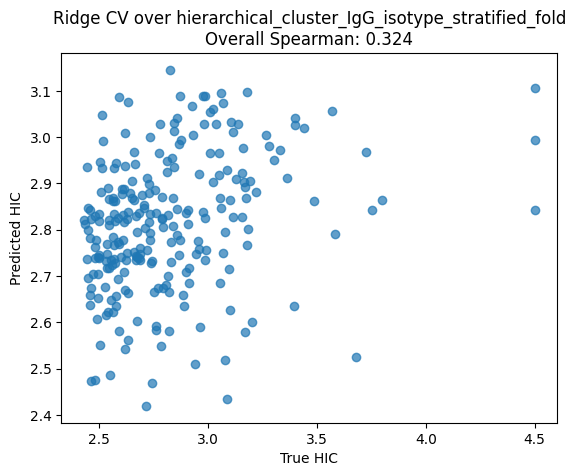

In [22]:
fold_col = "hierarchical_cluster_IgG_isotype_stratified_fold"
X = mean_pooled_embeddings
y = df[target].to_numpy(dtype=float)

# sanity check
assert len(X) == len(df) == len(y)

fold_values = df[fold_col].to_numpy()
unique_folds = [f for f in np.unique(fold_values) if f == f]  # drop NaN

per_fold_stats = []
y_pred_all = np.full(len(df), np.nan)   # align with df rows
y_true_all = np.full(len(df), np.nan)   # optional, for plotting/metrics

for f in unique_folds:
    test_idx = np.where(fold_values == f)[0]
    train_idx = np.where(fold_values != f)[0]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test,  y_test  = X[test_idx],  y[test_idx]

    lm = Ridge()
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)

    # write back into the positions of df
    y_pred_all[test_idx] = y_pred
    y_true_all[test_idx] = y_test

    rho = spearmanr(y_test, y_pred).statistic
    per_fold_stats.append((int(f), rho, len(y_test)))

# Overall metric across all rows that participated in CV
mask = ~np.isnan(y_true_all)
overall_rho = spearmanr(y_true_all[mask], y_pred_all[mask]).statistic

print(f"Averaged CV Spearman:\t{overall_rho:.4f}")

plt.figure()
plt.scatter(y_true_all[mask], y_pred_all[mask], alpha=0.7)
plt.title(f"Ridge CV over {fold_col}\nOverall Spearman: {overall_rho:.3f}")
plt.xlabel(f"True {target}")
plt.ylabel(f"Predicted {target}")
plt.show()

This gives us a Spearman correlation of about `0.324` for predicting `HIC` with a ridge regression model - a bit lower than when we used the random split, but this gives us a *more realistic* estimate of how well our model will generalize to new antibodies in the test set.

Now, to submit these predictions to the leaderboard, we write out to CSV:


In [23]:
GDPa_submission_CV  =  df[['antibody_name', 'vh_protein_sequence', 'vl_protein_sequence', 'hierarchical_cluster_IgG_isotype_stratified_fold']].copy()
GDPa_submission_CV[target] =  y_pred_all
GDPa_submission_CV.to_csv('gpda_cv_submission.csv', index=False)

## Using the model to submit test set predictions

Finally, we'd like to use this model to submit predictions on the test set. You can download the test set from the leaderboard and make embeddings as we did before:

In [25]:
# load from csv
testset_df  =  pd.read_csv('heldout-set-sequences.csv')

# make sequences
testset_sequences = [
    "1" + " ".join(heavy) + " ".join(light) + "2"
    for heavy, light in zip(
        testset_df["vh_protein_sequence"],
        testset_df["vl_protein_sequence"],
    )
]

# make embeddings
testset_embeddings = []
for i in tqdm(range(0, len(testset_sequences), batch_size)):
    batch = tokenizer(
        testset_sequences[i:i+batch_size],
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    outputs = model(
        batch["input_ids"].to(device),
        return_rep_layers=[-1],
        output_hidden_states=True,
    )
    embeddings = outputs["hidden_states"][-1].detach().cpu().numpy()
    testset_embeddings.append(embeddings.mean(axis=1))

testset_embeddings = np.concatenate(testset_embeddings)

  0%|          | 0/5 [00:00<?, ?it/s]

Then, we predict and write those predictions to CSV:


In [26]:
X  =  testset_embeddings
testset_y  =  lm.predict(X)
testset_submission  =  testset_df[['antibody_name', 'vh_protein_sequence', 'vl_protein_sequence']].copy()

testset_submission[target] =  testset_y

testset_submission.to_csv('testset_submission.csv', index=False)

Once you submit, you should see your result on the public competition leaderboard like this:
![image/png](https://cdn-uploads.huggingface.co/production/uploads/680ff4388f704be391757780/adTaFJo6UWEfw3t9N5Y8R.png)

Submit your own predictions now at the Antibody Developability Competition site: https://huggingface.co/spaces/ginkgo-datapoints/abdev-leaderboard